In [36]:
from typing import Any, Callable, Dict, Optional, Tuple, List
import xml.etree.ElementTree as Et
from xml.etree.ElementTree import Element, ElementTree

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision
from torchvision import utils
from torchvision import models
from torchvision import transforms
from torchvision.transforms.functional import to_tensor, to_pil_image

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2
import collections
import numpy as np

import os
import copy
import time

In [37]:
dataset_path = "../../../../../../data/preprocessing/"
classes = ["grass","tree","nest"]

In [38]:
class MyDataset(Dataset):
    def __init__(self, dataset_path, dataset_type, transform=None):
        self.path = dataset_path
        if dataset_type == "train": self.dataset_type = "train/"
        elif dataset_type == "test": self.dataset_type = "test/"
        elif dataset_type == "val": self.dataset_type = "val/"
        else: print("[Error Message] : Please check datatype") 
        
        try:
            self.ann_root, self.ann_dir, self.ann_files = next(os.walk(os.path.join(self.path, self.dataset_type, "Annotations")))
            self.img_root, self.amg_dir, self.img_files = next(os.walk(os.path.join(self.path, self.dataset_type, "JPEGImages")))
            self.images = [os.path.join(self.img_root, x)for x in self.img_files]
            self.targets = [os.path.join(self.ann_root, x)for x in self.ann_files]
            self.images.sort()
            self.targets.sort()

        except AttributeError as e: print(e)
        except StopIteration as e: print("[Error Message] : please check data path")
        
        self.transform = transform
            
    def __len__(self):
        return len(self.ann_files)

    def __getitem__(self, index):
        # Function to get the data from XML Annotation
        image = cv2.imread(self.images[index], cv2.IMREAD_COLOR)
        b, g, r = cv2.split(image)   # img파일을 b,g,r로 분리
        image = cv2.merge([r, g, b])  # b, r을 바꿔서 Merge
        target = self.parse_voc_xml(Et.parse(self.targets[index]).getroot())  # xml파일 분석하여 dict으로 받아오기

        targets = []    # 바운딩 박스 좌표
        labels = []     # 바운딩 박스 클래스
        
        # 바운딩 박스 정보 받아오기
        for t in target['annotation']['object']:
            label = np.zeros(5)
            label[:] = t['bndbox']['xmin'], t['bndbox']['ymin'], t['bndbox']['xmax'], t['bndbox']['ymax'], classes.index(t['name'])
            targets.append(list(map(int, label[:4])))
            labels.append(int(label[4]))

        return image, targets, tuple(labels)
    
    # xml 파일을 dictionary로 반환
    def parse_voc_xml(self, node: Et.Element) -> Dict[str, Any]:
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict


In [39]:
train_ds = MyDataset(dataset_path, "train")
val_ds = MyDataset(dataset_path, "val")
test_ds = MyDataset(dataset_path, "test")
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))
print(test_ds[0][0].shape)

5974
312
417
(800, 800, 3)


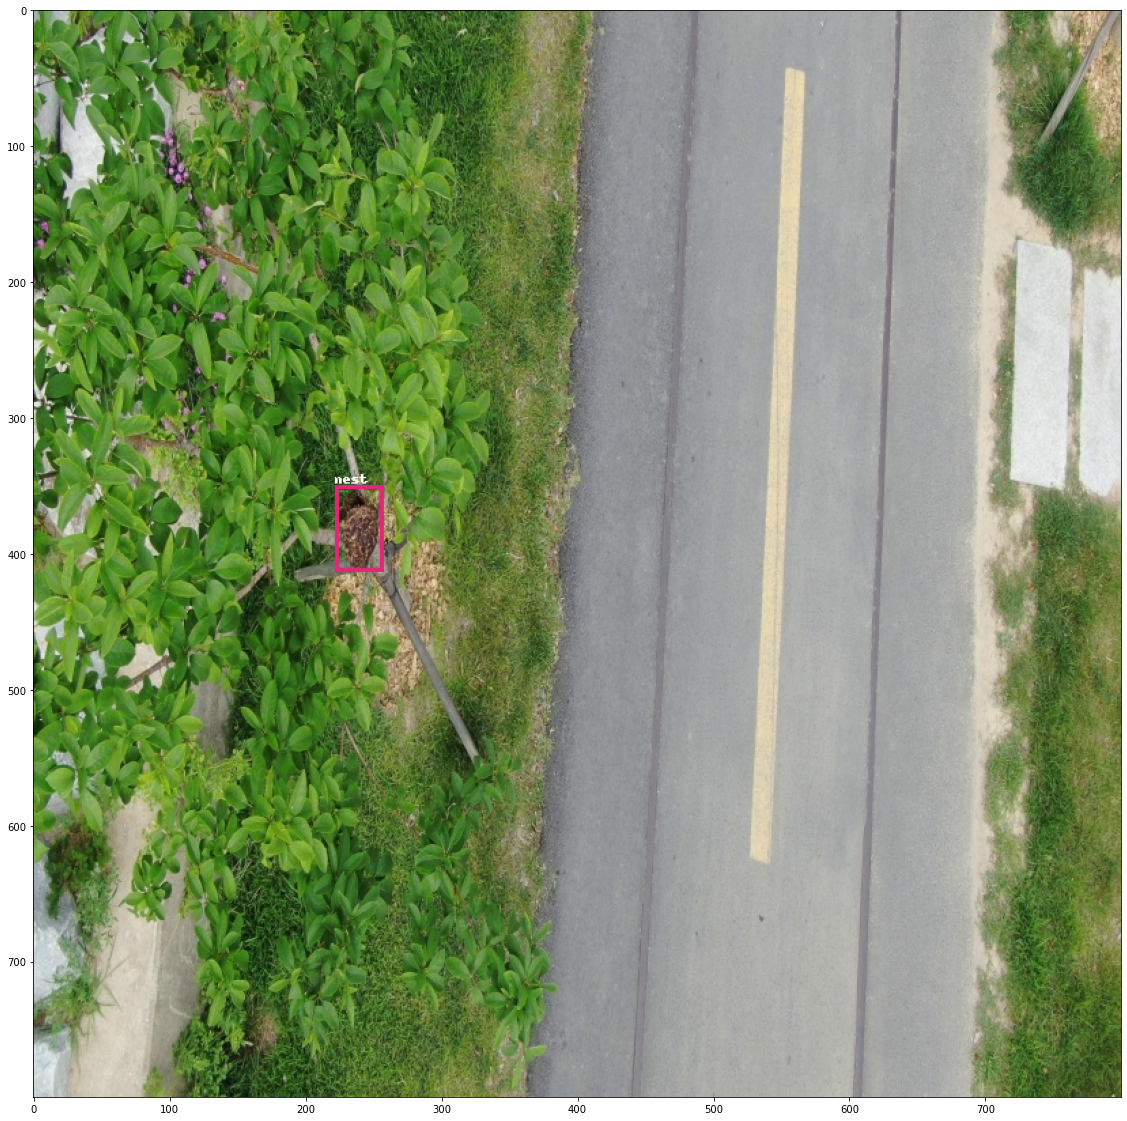

In [40]:
# 샘플 이미지 확인
img, target, label = val_ds[-1]
colors = np.random.randint(0, 255, size=(80, 3), dtype='uint8')  # 바운딩 박스 색상

# 시각화 함수


def show(img, targets, labels, classes=classes):
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)
    targets = np.array(targets)
    W, H = img.size

    for tg, label in zip(targets, labels):
        id_ = int(label)  # class
        bbox = tg[:4]    # [x1, y1, x2, y2]

        color = [int(c) for c in colors[id_]]
        name = classes[id_]

        draw.rectangle(((bbox[0], bbox[1]), (bbox[2], bbox[3])),outline=tuple(color), width=3)
        draw.text((bbox[0], bbox[1]-10), name, fill=(255, 255, 255, 0))
        
    plt.imshow(np.array(img))


plt.figure(figsize=(20, 20))
show(img, target, label)

In [41]:
train_dl = DataLoader(train_ds, batch_size=2,shuffle=True)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=True)

In [42]:
print(len(train_dl))
print(len(val_dl))

2987
156


In [43]:
for tensor_img,xy,label in train_dl:
    print(f"tensor_img_shape : {tensor_img.shape}\n")
    print(f"xy : {xy}\n")
    print(f"label : {label}\n")
    break

tensor_img_shape : torch.Size([2, 800, 800, 3])

xy : [[tensor([637,  26]), tensor([107, 496]), tensor([717, 138]), tensor([262, 691])]]

label : [tensor([2, 2])]



In [44]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [61]:
# only print feature extraction part of VGG16

model = torchvision.models.vgg16(pretrained=True).to(device)
features = list(model.features)
print(len(features))
print(features)


31
[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [65]:
# only collect layers with output feature map size (W, H) < 50

dummy_img = torch.zeros((1, 3, 800, 800)).float()  # test image array
print(dummy_img.shape)

req_features = []
output = dummy_img.clone().to(device)

for feature in features:
    output = feature(output)
    # print(output.size()) # => torch.Size([batch_size, channel, width, height])
    if output.size()[2] < 800//16:  # 800/16=50
        break
    req_features.append(feature)
    out_channels = output.size()[1]

print(len(req_features))
# print(req_features)
print(out_channels)

torch.Size([1, 3, 800, 800])
30
512


In [58]:
feature_map_size = (50, 50)
# The first center coors is (8, 8)
ctr_y = np.arange(8, 800, 16)
ctr_x = np.arange(8, 800, 16)

ctr = np.zeros((*feature_map_size, 2))
for idx, y in enumerate(ctr_y):
    ctr[idx, :, 0] = y
    ctr[idx, :, 1] = ctr_x
print(ctr.shape)

(50, 50, 2)


In [63]:
# convert this list into a Seqeuntial module

faster_rcnn_feature_extractor = nn.Sequential(*req_features)

In [ ]:
# test the results of the input image pass through the feature extractor

transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
output_map = faster_rcnn_feature_extractor(imgTensor)

print(output_map.size())

In [ ]:
# 모델 fine-tune fc layer만 학습
for param in backbone.parameters():
    param.requires_grad = False

In [35]:
criterion = nn.CrossEntropyLoss()
print(backbone.parameters())
# Optimizer에는 requires_grad=True 인 parameters들만 들어갈수 있습니다.
optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, backbone.parameters()), lr=0.001)


<generator object Module.parameters at 0x7f70b4210040>


ValueError: optimizer got an empty parameter list